In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [2]:
nonface_dataset_path = 'nonface_archive'
face_dataset_path = 'archive'

nonface_dirs, face_dirs = os.listdir(nonface_dataset_path), os.listdir(face_dataset_path)
nonface_data, face_data = np.zeros((400,10304)), np.zeros((400,10304))
nonface_labels, face_labels = np.zeros((400,1)), np.ones((400,1))

cnt=0
paths = ["archive/s" + str(i) for i in range(1,41)]
for path in paths:
    files = os.listdir(path)
    for file in files:
        img = Image.open(path + "/" + file)
        np_img = np.array(img)
        np_img = np_img.flatten()
        face_data[cnt]=np_img
        cnt+=1

cnt=0
paths = ["nonface_archive/s" + str(i) for i in range(1,9)]
for path in paths:
    files = os.listdir(path)
    for file in files:
        img = Image.open(path + "/" + file)
        np_img = np.array(img)
        np_img = np_img[:,:,0].flatten()
        nonface_data[cnt] = np_img
        cnt += 1

In [3]:
data = np.append(face_data, nonface_data, axis=0)
labels = np.append(face_labels, nonface_labels, axis=0)

training_set = data[0:800:2]
test_set = data[1:800:2]

training_labels = labels[0:800:2]
test_labels = labels[1:800:2]

In [4]:
def process_data(training_set,test_set):
    means = np.mean( training_set, axis=0 )

    # we need to reshape the means vector to be a row vector to be able to broadcast it with the training set and test set
    means = means.reshape( 1, 10304 )

    centered_training_set = training_set - means
    centered_test_set = test_set - means

    # bias=True is used to divide by N instead of N-1 (where N is the number of samples)
    covariance_matrix = np.cov( centered_training_set.T, bias=True )
    
    # we use eigh instead of eig because the covariance matrix is symmetric and won't have complex eigenvalues
    # (eigh is faster and doesn't compute the eigenvectors of the complex conjugate pairs which are not needed)
    eigenvalues, eigenvectors = np.linalg.eigh( covariance_matrix )

    positions = eigenvalues.argsort()[::-1]
    sorted_eigenvalues = ( eigenvalues[positions] )
    sorted_eigenvectors = ( eigenvectors[:, positions] )
        
    return sorted_eigenvalues, sorted_eigenvectors, centered_training_set, centered_test_set

### Classification using PCA

In [5]:
# Best alpha from the PCA section is 0.8
alpha = 0.8

def get_pca(eigenvalues, eigenvectors, alpha):
    total = sum( eigenvalues )
    r = 0
    current_sum = 0
    while current_sum / total < alpha:
        current_sum += eigenvalues[r]
        r += 1
    new_space = eigenvectors[:, :r]
    return new_space

sorted_eigenvalues, sorted_eigenvectors, centered_training_set, centered_test_set = process_data( training_set, test_set )
new_space = get_pca( sorted_eigenvalues, sorted_eigenvectors, alpha )
new_training_set = np.dot( centered_training_set, new_space )
new_test_set = np.dot( centered_test_set, new_space )

knn = KNeighborsClassifier( n_neighbors=1 )

knn.fit( new_training_set, training_labels.ravel() )
knn.score( new_test_set, test_labels.ravel() )

0.935

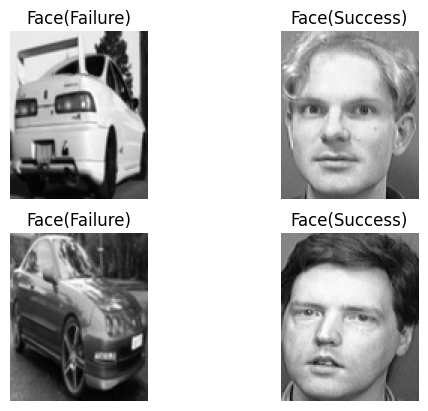

In [54]:
# show 4 random test images and their predictions in subplots
fig, axs = plt.subplots( 2, 2 )
for i in range( 2 ):
    for j in range( 2 ):
        index = np.random.randint( 0, 400 )
        axs[i, j].imshow( test_set[index].reshape( 112, 92 ), cmap='gray' )
        prediction = knn.predict( new_test_set[index].reshape( 1, -1 ) )
        axs[i, j].set_title( ('Face' if prediction == 1 else 'Nonface') + ('(Failure)' if test_labels[index] != prediction else '(Success)') )
        axs[i, j].axis( 'off' )
plt.show()

### Classification using LDA